In [6]:
import json
import numpy as np
import time
import matplotlib.pyplot as plt
from pandas import DataFrame
from datetime import datetime,timedelta
from yfinance import Tickers

from allocator import WeightOptimizer
from evaluation import Evaluation

In [7]:
with open("assets.json") as assets_file:
    assets = json.load(assets_file)
tickers = Tickers(assets)
num_assets = len(assets)

In [ ]:
n_iter = 30000
lr = 1e-3
risk_free = 0.027
rf_period = timedelta(252) #252 trading days per year
w_decay = 0.1

alpha = 0.3
beta = 0.1 
gamma = 0.6 

start_date = datetime(2017,1,1)
end_date = datetime(2024,1,1)
lookback = timedelta(365)
eval_period = timedelta(30*3)


In [9]:
start = time.time()
allocator = WeightOptimizer(n_iter,lr,num_assets,risk_free,rf_period,w_decay)
algo = allocator.optimize_weights
evaluator = Evaluation(algo,tickers,start_date,end_date,lookback,eval_period)
opt_returns, comp_returns = evaluator.compare_returns(calmar_co=alpha,omega_co=beta,sortino_co=gamma, device='cpu',silent=True)
end = time.time()

[*********************100%***********************]  30 of 30 completed


✅ Return series is backward-looking — no leakage.


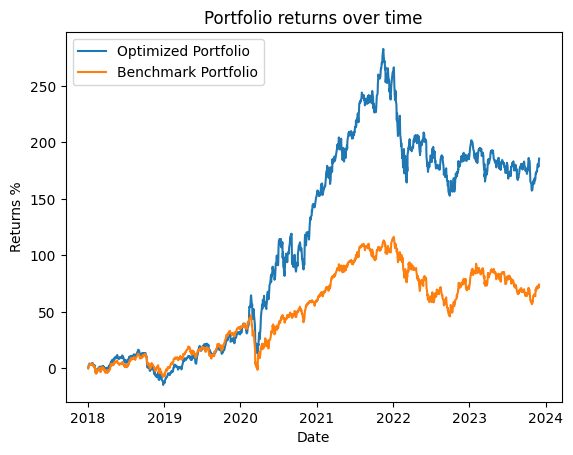

Compute time: 23 min 26 s
------------------------------------------------------------
Optimized Portfolio Total Return: 142.98%
Optimized Portfolio Annualized Return: 16.04%
Optimized Portfolio Sharpe Ratio: 0.57
------------------------------------------------------------
Benchmark Portfolio Total Return: 55.60%
Benchmark Portfolio Annualized Return: 7.69%
Benchmark Portfolio Sharpe Ratio: 0.26


In [10]:
final_weights = DataFrame(evaluator.final_weights,index=assets,columns=['Weights %'])*100
final_weights.index.name = 'Tickers'
final_weights.to_csv('eval_weights.csv',index=True) #Weights for last period evaluated

opt_daily_mult = 1 + opt_returns
comp_daily_mult = 1 + comp_returns

#Total returns
opt_tot_ret = opt_daily_mult.prod() - 1
comp_tot_ret = comp_daily_mult.prod() - 1

# Annualized returns
n_days = len(opt_daily_mult)
n_years = n_days / 252

opt_annual_ret = (1 + opt_tot_ret) ** (1/n_years) - 1
comp_annual_ret = (1 + comp_tot_ret) ** (1/n_years) - 1

#Volatility 
opt_vol = opt_returns.std() * np.sqrt(252)
comp_vol = comp_returns.std() * np.sqrt(252)

#Sharpe
opt_sharpe = (opt_annual_ret - risk_free) / opt_vol
comp_sharpe = (comp_annual_ret - risk_free) / comp_vol

#Cumulative returns
c_opt_ret = np.exp(opt_returns.cumsum()) - 1
c_comp_ret = np.exp(comp_returns.cumsum()) - 1

plt.plot(c_opt_ret*100, label='Optimized Portfolio')
plt.plot(c_comp_ret*100, label='Benchmark Portfolio')
plt.title('Portfolio returns over time')
plt.xlabel('Date')
plt.ylabel('Returns %')
plt.legend()
plt.show()

elapsed_time = end - start
m, s = divmod(elapsed_time,60)

print(f"Compute time: {m:.0f} min {s:.0f} s")
print ('------------------------------------------------------------')  
print(f"Optimized Portfolio Total Return: {opt_tot_ret:.2%}")
print(f"Optimized Portfolio Annualized Return: {opt_annual_ret:.2%}")
print(f"Optimized Portfolio Sharpe Ratio: {opt_sharpe:.2f}")
print ('------------------------------------------------------------')  
print(f"Benchmark Portfolio Total Return: {comp_tot_ret:.2%}")
print(f"Benchmark Portfolio Annualized Return: {comp_annual_ret:.2%}")
print(f"Benchmark Portfolio Sharpe Ratio: {comp_sharpe:.2f}")